##Building first cut models

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
provider=pd.read_csv('/content/drive/MyDrive/provider.csv')
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Doing the train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(provider.drop('PotentialFraud',axis=1),provider['PotentialFraud'],test_size=0.2,stratify=provider['PotentialFraud'],random_state=42)

Lets find out correlation amongst feature variables.

**Feature selection**

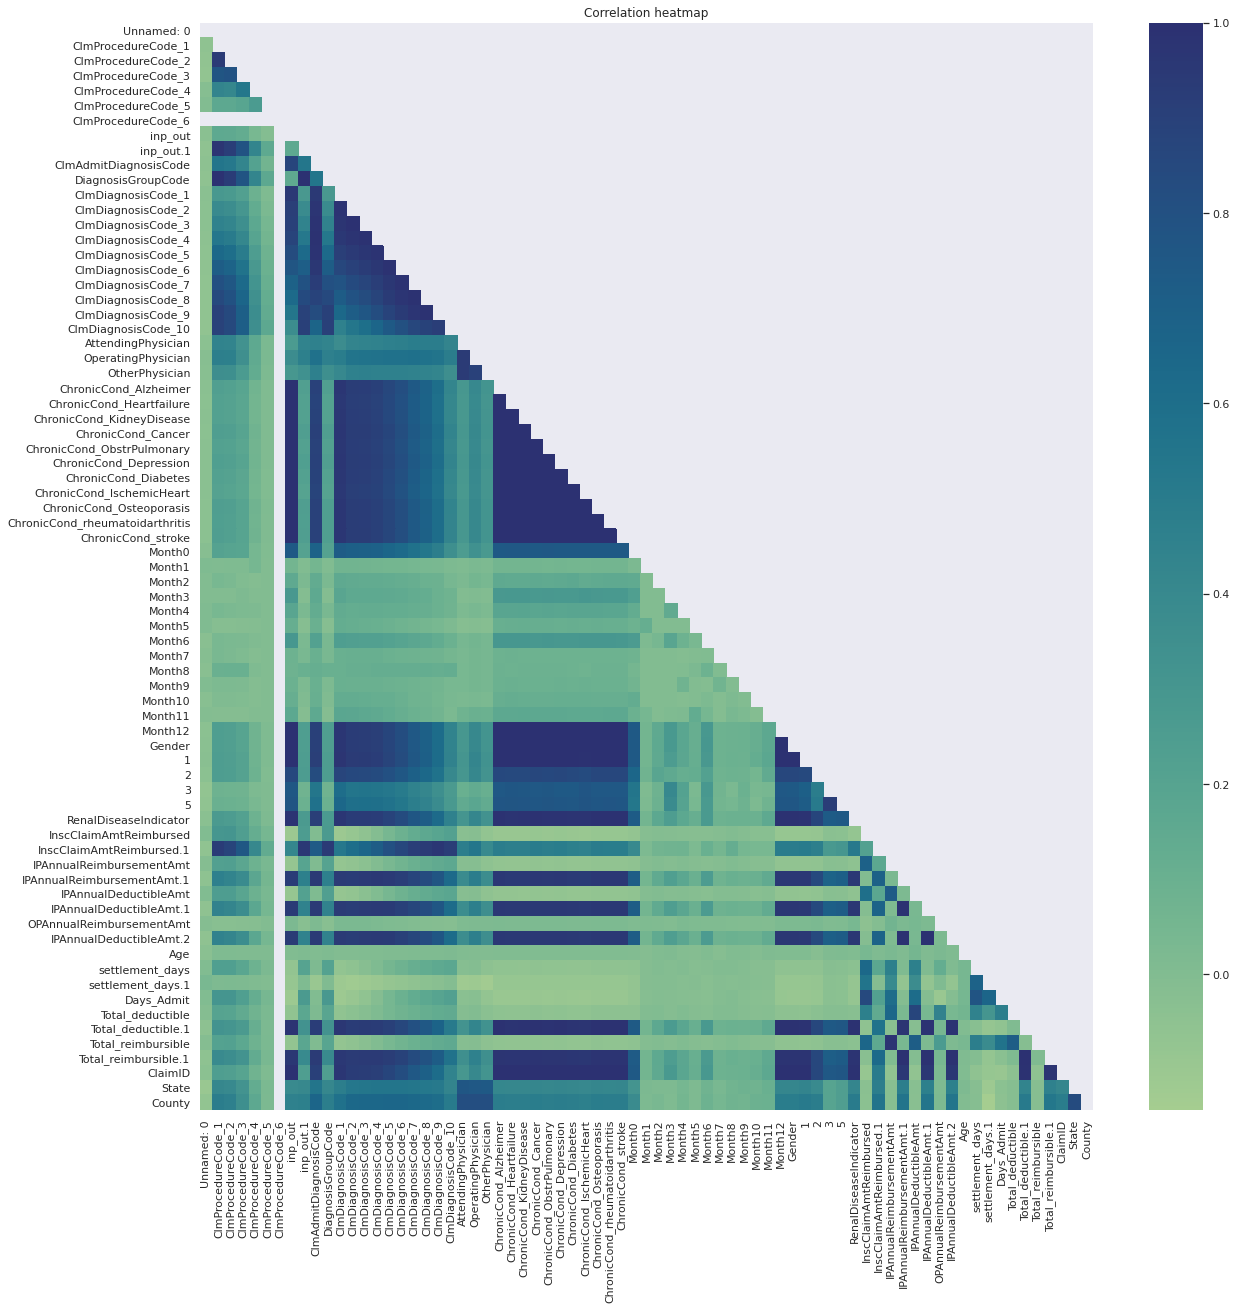

In [ ]:
#finding the correlation amongst features
plt.figure(figsize=(20, 20))
plt.title('Correlation heatmap')
corr=X_train.corr()
mask=np.triu(corr)
sns.heatmap(corr,cmap='crest',mask=mask)
plt.show()

In [ ]:
up=corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))

In [ ]:
td=[col for col in up.columns if any(abs(up[col])>0.99)]

Dropping the highly correlated features..

In [ ]:
X_train.drop(td,axis=1,inplace=True)
X_test.drop(td,axis=1,inplace=True)

Visualizing using a TSNE plot..

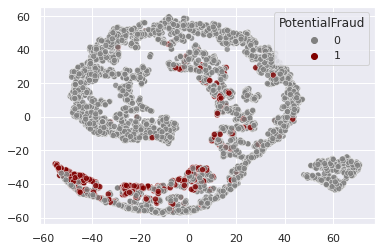

In [ ]:
from sklearn.manifold import TSNE
colors=['gray','maroon']
customPalette = sns.set_palette(sns.color_palette(colors))
prov_emb=TSNE(n_components=2,perplexity=40,n_iter=1000).fit_transform(X_train.drop('Provider',axis=1))
sns.scatterplot(x=prov_emb[:,0],y=prov_emb[:,1],hue=y_train,palette=customPalette,alpha=0.8)

From TSNE plot we observe both classes are somewhat separable with non fraud class observation spread all over and fraudulent ones 

In [ ]:
# prv_id=provider['Provider']
X_train.drop('Provider',axis=1,inplace=True)
X_test.drop('Provider',axis=1,inplace=True)

Lets find which features are important in making prediction..

In [ ]:
from sklearn.ensemble import RandomForestClassifier
r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
# predict_y = r_cfl.predict(provider.drop('PotentialFraud',axis=1))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

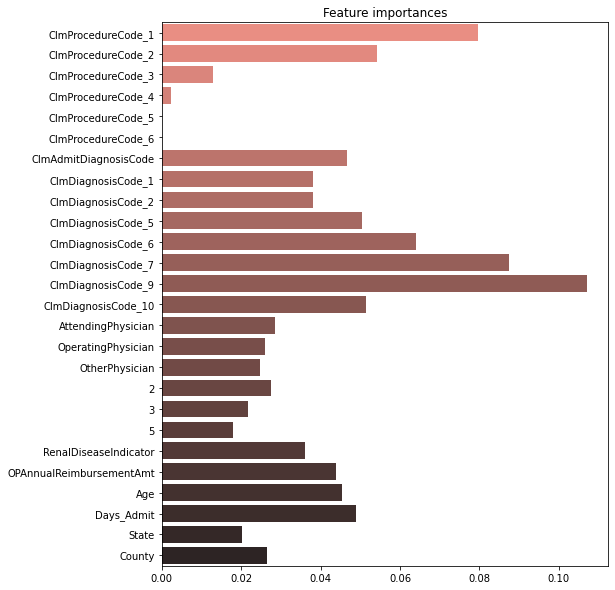

In [ ]:
features=X_train.columns
coef = pd.Series(r_cfl.feature_importances_,features).sort_values()
plt.figure(figsize=(8,10))
plt.title('Feature importances')
sns.barplot(x=r_cfl.feature_importances_,y=features,palette='dark:salmon_r')
plt.show()

We see that features like procedurecode5,6 are not contributing much in prediction of random forest model. So we decide to drop these features.

In [ ]:
#dropping less important features
coef=coef[coef<0.01].index
X_train.drop(coef,axis=1,inplace=True)
X_test.drop(coef,axis=1,inplace=True)

As we have already seen there was class imbalance we need to address the issue before moving forward. We can try following approaches

-Resampling (Over sampling)

-Creating synthetic samples of minority class

-Balancing class weights

-Clustering based resampling

-Clustering based sampling and aggregation

#Modelling

In [ ]:
def Heatmapgen(x):
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea referred from here
  group_names = ['True -ve','False +ve','False -ve','True +ve']
  group_counts = ['{0:0.0f}'.format(value) for value in x.flatten()]
  labels = [f'{v1}\n{v2}' for v1, v2 in
  zip(group_names,group_counts)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(x, annot=labels, fmt='', cmap='RdBu')

Random Oversampling

In [ ]:
#Random oversampling
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
from sklearn.metrics import f1_score
r_cfl=RandomForestClassifier(n_estimators=1000,random_state=21,n_jobs=-1)
r_cfl.fit(X_over,y_over)
predict_y = r_cfl.predict(X_test)
print('F1 score on oversampled data:',f1_score(y_test,predict_y))

F1 score on oversampled data: 0.6532663316582915


Synthetic minority oversampling(SMOTE)

In [ ]:
#Synthetic oversampling
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_synt, y_synt = oversample.fit_resample(X_train, y_train)

In [ ]:
r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
r_cfl.fit(X_synt,y_synt)
predict_y = r_cfl.predict(X_test)
print('F1 score on oversampled data:',f1_score(y_test,predict_y))

F1 score on oversampled data: 0.5833333333333334


Class weights balancing

In [ ]:
#using balanced class weights
r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1,class_weight='balanced_subsample')
r_cfl.fit(X_train,y_train)
predict_y = r_cfl.predict(X_test)
print('F1 score on oversampled data:',f1_score(y_test,predict_y))

F1 score on oversampled data: 0.6046511627906976


Cluster based resampling:

https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set


Idea: 

In this approach we will divide the majority class data into *k* clusters where *k* being the number of points in the minority class. Then of these cluster we can find the cluster centroids and use it instead of majority class data. Now due to resampling we have our classes balanced.

In [ ]:
#clustering based resampling
from sklearn.cluster import KMeans
model = KMeans(n_clusters=y_train.value_counts()[1]) #making same number of clusters as minority class
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=455, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
X_clust=model.cluster_centers_
X_pos=X_train[y_train==1]
X_clust=np.vstack((X_pos.values,X_clust))
y_clust=[1 if i>455 else 0 for i in range(910)]

In [ ]:
r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
r_cfl.fit(X_clust,y_clust)
predict_y = r_cfl.predict(X_test)
print('F1 score on oversampled data:',f1_score(y_test,predict_y))

F1 score on oversampled data: 0.27522935779816515


https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set

Clustering and aggregation:

Idea:

In order to handle class imbalance we can divide the abundant class labels into *L* number of clusters.Then we will build *L* models each of which will be trained on (individual cluster+minority class data).We will evaluate on test set data. After getting the predictions we will do a majority vote and predict the majority as class label

In [ ]:
X_neg=X_train[y_train==0]
X_pos=X_train[y_train==1]
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3,tol=0.001,max_iter=500,n_init=20) #making same number of clusters as minority class
model.fit(X_neg)
label=model.labels_

In [ ]:
predictions=[]
for i in range(5):
  X_1=np.vstack((X_pos,X_neg[label==i]))
  y_1=[1 if i<455 else 0 for i in range(455+len(X_neg[label==i]))]
  r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
  r_cfl.fit(X_1,y_1)
  predict_y = r_cfl.predict(X_test)
  predictions.append(predict_y)
  print('F1 score on oversampled data:',f1_score(y_test,predict_y,average='macro'))
  # plot_confusion_matrix(y_test,predict_y)

F1 score on oversampled data: 0.7116204690831557
F1 score on oversampled data: 0.10278227010991048
F1 score on oversampled data: 0.20349709147691203
F1 score on oversampled data: 0.08614864864864864
F1 score on oversampled data: 0.08614864864864864


In [ ]:
sum=0
for i in predictions:
  sum+=i
y_pred=np.where(sum>2,1,0)
f1_score(y_test,y_pred)

0.17229729729729729

Repeated random undersampling and aggregation

Idea:

We can randomly sample points from majority class labels of size same as minority class labels. Then we will build *k* such classifiers on (sampled data+minority class data). We will get the predictions from *k* models and will do a majority vote to predict the final output.

In [ ]:
predictions=[]
for i in range(11):
  ch=int(np.random.uniform(0,3900))                   #randomly selecting samples from majority class
  X_samp=X_neg.iloc[ch:ch+455]
  X_clust=np.vstack((X_pos.values,X_samp))            #stacking both +ve sampled class and -ve class and training
  y_clust=[1 if i<455 else 0 for i in range(910)]
  r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
  r_cfl.fit(X_clust,y_clust)
  predict_y = r_cfl.predict(X_test)                   #predicting on test data
  predictions.append(predict_y)
  print('F1 score:',f1_score(y_test,predict_y))

F1 score: 0.48275862068965514
F1 score: 0.5030674846625767
F1 score: 0.49696969696969695
F1 score: 0.4938271604938272
F1 score: 0.49710982658959546
F1 score: 0.4912280701754386
F1 score: 0.49438202247191004
F1 score: 0.5185185185185186
F1 score: 0.4970414201183432
F1 score: 0.47953216374269014
F1 score: 0.5060240963855422


In [ ]:
#based on majority votes predicting the f1 score
sum=0
for i in predictions:
  sum+=i
y_pred=np.where(sum>5,1,0)
f1_score(y_test,y_pred)  

0.4939759036144578

From above trials we saw that simple oversampling of minority class labels gave a high F1 score the complex methods.

With this we are ready for modelling. We will use random oversampling and class weight balancing technique to address the class imbalance..

**Model Building**

We wiil be using oversampling method in order to address class imbalance. But we cannot use oversampled data for validation as it will cause data leakage. Instead we will build a pipeline to ensure there is no leakage whatsoever..

Below blog explains it beautifully..

https://medium.com/lumiata/cross-validation-for-imbalanced-datasets-9d203ba47e8#:~:text=Techniques%20like%20oversampling%2FSMOTE%20help,exclude%20some%20data%20for%20validation.

**1 K Nearest Neighbors**

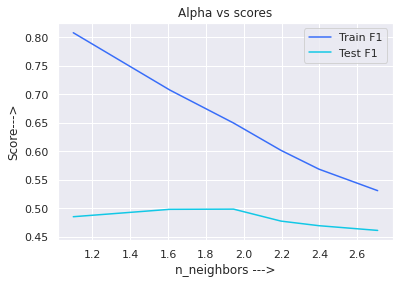

Best estimator : {'model__n_neighbors': 7}
Best score: 0.49856166697779314


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
steps=list()
param={'model__n_neighbors':[3,5,7,9,11,15]}
steps.append(('scaler', StandardScaler()))
steps.append(('sampling',RandomOverSampler()))
steps.append(('model', KNeighborsClassifier()))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=10, scoring='f1',return_train_score=True)
clf.fit(X_train,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__n_neighbors')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [math.log(i) for i in result_clf['param_model__n_neighbors']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('n_neighbors --->')
plt.ylabel('Score--->')
plt.title('Alpha vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [ ]:
q=clf.predict(X_test)
print('Test F1 score:',f1_score(y_test,q))

Test F1 score: 0.5578231292517007


**2 Naive Bayes classifier**

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf=GaussianNB(priors=[0.9,0.1])
clf.fit(X_train,y_train)
ytr_pred=clf.predict(X_train)
print('Train set F1 score :',f1_score(y_train,ytr_pred))
q=clf.predict(X_test)
print('Test set F1 score :',f1_score(y_test,q))

Train set F1 score : 0.514745308310992
Test set F1 score : 0.5365853658536587


**3 SVM**

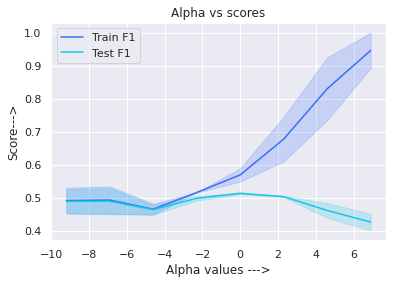

Best estimator : {'model__C': 0.001, 'model__gamma': 'scale'}
Best score: 0.5283227867470149


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
import math
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
steps=list()
param={'model__C':[10**i for i in range(-4,4)],'model__gamma':['scale','auto']}
steps.append(('scaler', StandardScaler()))
steps.append(('sampling',RandomOverSampler()))
steps.append(('model', SVC()))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=10, scoring='f1',return_train_score=True)
clf.fit(X_train,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__C')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [math.log(i) for i in result_clf['param_model__C']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('Alpha values --->')
plt.ylabel('Score--->')
plt.title('Alpha vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [ ]:
q=clf.predict(X_test)
print('Test F1 score:',f1_score(y_test,q))

Test F1 score: 0.5766423357664234


**4.DecisionTree**

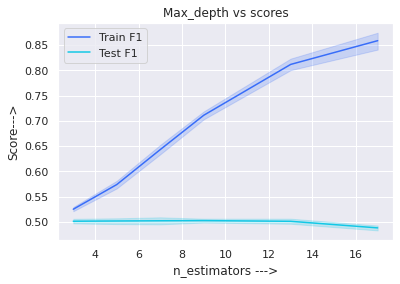

Best estimator : {'model__criterion': 'gini', 'model__max_depth': 7, 'model__min_samples_leaf': 5, 'model__min_samples_split': 3}
Best score: 0.5522671272308578


In [ ]:
from sklearn.tree import DecisionTreeClassifier
param={'model__max_depth':[3,5,7,9,13,17]
       ,'model__min_samples_split':[3,5,7,11]
       ,'model__criterion':['gini','entropy'],
       'model__min_samples_leaf':[1,3,5,7,11]
       }
steps=[]
steps.append(('sampling',RandomOverSampler()))       
steps.append(('model', DecisionTreeClassifier()))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=3, scoring='f1',return_train_score=True)
clf.fit(X_train.values,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__max_depth')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [i for i in result_clf['param_model__max_depth']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('n_estimators --->')
plt.ylabel('Score--->')
plt.title('Max_depth vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [ ]:
q=clf.predict(X_test.values)
f1_score(q,y_test)

0.49844236760124616

**5 Logistic Regression**

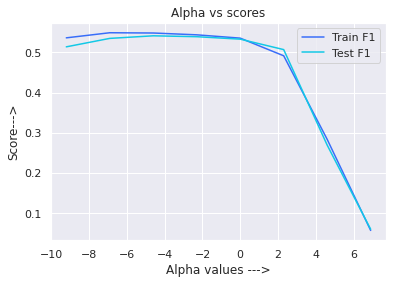

Best estimator : {'model__alpha': 0.01}
Best score: 0.5406461299468142


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
steps=list()
param={'model__alpha':[10**i for i in range(-4,4)]}
steps.append(('scaler', StandardScaler()))
steps.append(('sampling',RandomOverSampler()))
steps.append(('model', SGDClassifier()))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=10, scoring='f1',return_train_score=True)
clf.fit(X_train,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__alpha')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [math.log(i) for i in result_clf['param_model__alpha']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('Alpha values --->')
plt.ylabel('Score--->')
plt.title('Alpha vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [ ]:
q=clf.predict(X_test)
print('Test F1 score:',f1_score(y_test,q))

Test F1 score: 0.5506329113924051


In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names=['Sl No','Classifier Name','Train/Validation F1_scr','Test F1_Scr']
x.add_row([1,'KNN',0.498,0.557])
x.add_row([2,'Naive Bayes',0.514,0.576])
x.add_row([3,'SVM(rbf)',0.528,0.576])
x.add_row([4,'DecisionTree',0.552,0.498])
x.add_row([5,'Logistic Regression',0.540,0.550])
print(x)

+-------+---------------------+-------------------------+-------------+
| Sl No |   Classifier Name   | Train/Validation F1_scr | Test F1_Scr |
+-------+---------------------+-------------------------+-------------+
|   1   |         KNN         |          0.498          |    0.557    |
|   2   |     Naive Bayes     |          0.514          |    0.576    |
|   3   |       SVM(rbf)      |          0.528          |    0.576    |
|   4   |     DecisionTree    |          0.552          |    0.498    |
|   5   | Logistic Regression |           0.54          |     0.55    |
+-------+---------------------+-------------------------+-------------+


Now we will be trying out ensembles to boost performance..

In [ ]:
#storing the files for ensemble modelling
X_train['y_train']=y_train
X_test['y_test']=y_test
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')